In [36]:
import random
import numpy as np
import cv2
import os
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from os.path import join
from os import listdir
from torchsummary import summary
import time
import zipfile
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

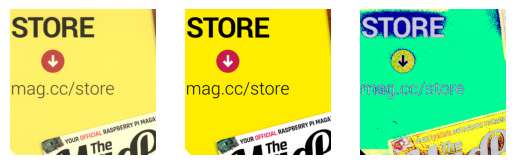

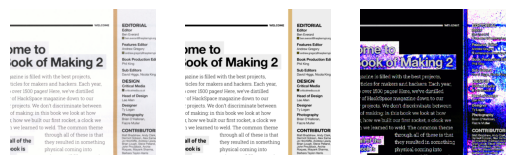

torch.Size([512, 512, 3])
tensor([[1, 0, 2],
        [1, 0, 2],
        [1, 0, 2],
        ...,
        [1, 0, 2],
        [1, 0, 2],
        [1, 0, 2]], dtype=torch.uint8)


In [102]:
display_number = 2                                     # plt로 디스플레이할 이미지의 개수
residual_output_paths = '/content/residuals'           # 잔차 이미지를 저장할 폴더
noisy_image_paths = '/content/dataset/train/scan'
clean_image_paths = '/content/dataset/train/clean'

output = False                                         # residual을 파일로 출력할지 여부


def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

class CustomDatasetTest(data.Dataset):
    def __init__(self, noisy_image_paths, transform=None):
        self.noisy_image_paths = [join(noisy_image_paths, x) for x in listdir(noisy_image_paths)]
        self.transform = transform

    def __len__(self):
        return len(self.noisy_image_paths)

    def __getitem__(self, index):
        
        noisy_image_path = self.noisy_image_paths[index]
        noisy_image = load_img(self.noisy_image_paths[index])
        
        if self.transform:
            noisy_image = self.transform(noisy_image)

        return noisy_image, noisy_image_path




# 데이터셋 로드 및 전처리
noisy_dataset = CustomDatasetTest(noisy_image_paths)
clean_dataset = CustomDatasetTest(clean_image_paths)

# 데이터 로더 설정
noisy_loader = DataLoader(noisy_dataset, batch_size=1, shuffle=False)
clean_loader = DataLoader(clean_dataset, batch_size=1, shuffle=False)


residuals = torch.Tensor(51, 512, 512, 3)
for i, ((noisy_image, noisy_image_path), (clean_image, clean_image_path) ) in enumerate(zip(noisy_loader,clean_loader)):
    residual_image = clean_image[0]-noisy_image[0]
    residuals[i] = residual_image
    if(i<display_number):
        plt.subplot(1,3,1)
        plt.imshow(noisy_image[0])
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(clean_image[0])
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(residual_image)
        plt.axis('off')
        plt.show()

    if output:
        output_filename = noisy_image_path[0]
        residual_filename = residual_output_paths + '/' + output_filename.split('\\')[-1][:-4].replace('\\',"/") + '.png'
        cv2.imwrite(residual_filename, np.array(residual_image))
    
    if(i==50):
        print(residual_image.shape)
        print(residual_image[0])
        break

avg_residual = torch.mean(residuals,axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


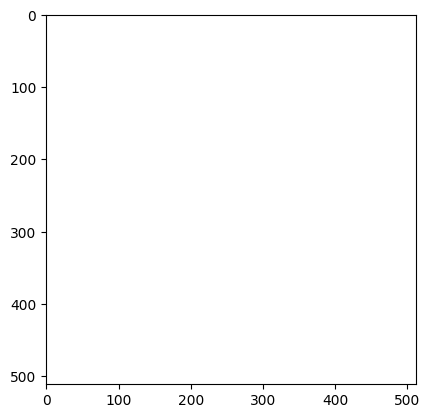

In [97]:
plt.imshow(np.clip(avg_residual,0,255))

In [98]:
avg_residual.shape

torch.Size([512, 512, 3])